# Predict Last two weeks
In Model-selection.ipynb you can see that XGBoost performs orders of magnitudes better then the other models. However it has already seen the test data. I have the suspicion that it is just overfitted to that data. To control for that we are going to perform a timebased CV.

In [86]:
# Imports
import pandas as pd
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
from sklearn.metrics import mean_squared_error as mse
df = pd.read_csv("../data/finalData2.csv")
df['time'] = pd.to_datetime(df['time'])
df.drop(["Unnamed: 0",'oerlikon'],axis = 1  ,inplace=True)
stop = df['time'].iloc[-1]
start = stop - pd.Timedelta(weeks=5)
timemask = (df['time'] >= start) & (df['time'] <= stop)
time = df['time']
df.drop('time', axis = 1, inplace = True)
X_train = df[timemask == 0].drop('city', axis = 1)
y_train = df[timemask == 0]['city']
X_test = df[timemask].drop('city', axis = 1)
y_test = df[timemask]['city']

# XGBoost

In [47]:
import xgboost as xgb
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train)
xgb_preds = reg.predict(X_test)

# Neural networks
Here we only look at the all features network

In [55]:
model = keras.Sequential()
model.add(keras.layers.InputLayer(shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(1024, activation="relu"))
model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(65, activation="relu"))
model.add(keras.layers.Dense(1, activation="linear"))

model.compile(
    loss=keras.losses.MeanSquaredError(name="MSE"),
    optimizer=keras.optimizers.Adam(learning_rate=1e-5)
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=4),
]

batch_size = 100
epochs = 100
model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.15,
    callbacks=callbacks,
)

2667/2667 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - loss: 579.9258 - val_loss: 580.9798
Epoch 12/100
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - loss: 573.9470 - val_loss: 675.1512
Epoch 13/100
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - loss: 562.4661 - val_loss: 656.4525
Epoch 14/100
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - loss: 551.1574 - val_loss: 649.4941
Epoch 15/100
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - loss: 537.4931 - val_loss: 596.8623


In [82]:
model.save("../models/NN-slow-allfeatures.keras")

In [57]:
nn_preds = model.predict(X_test)

3098/3098 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step


# Visualize


TypeError: annotate() missing 1 required positional argument: 'xy'

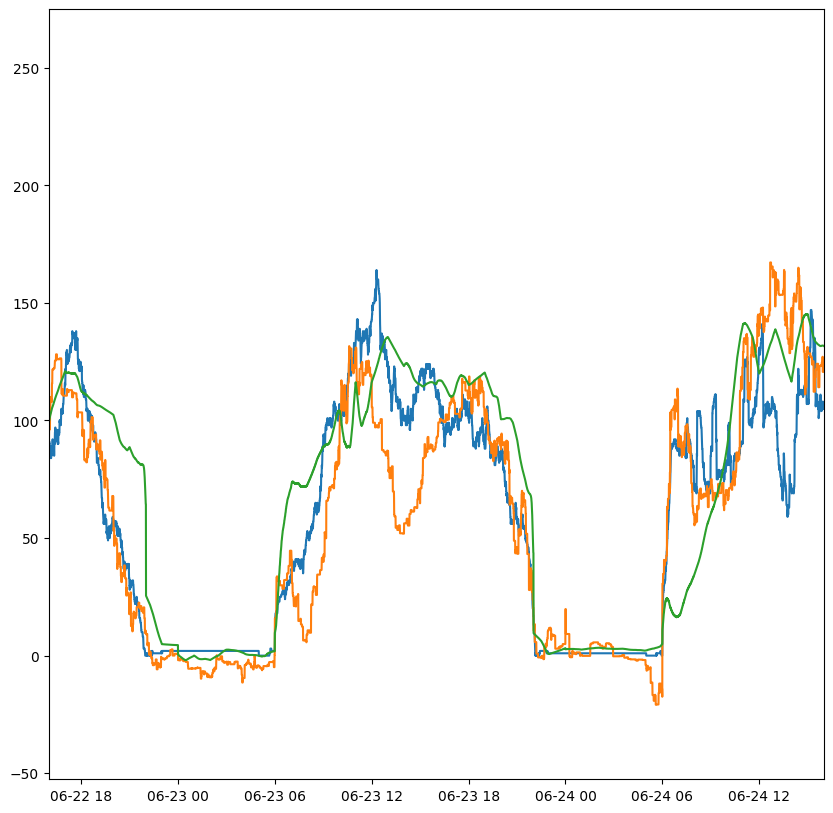

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(time[timemask], y_test, label = "Data")
plt.plot(time[timemask], xgb_preds, label = "XGBoost")
plt.plot(time[timemask], nn_preds, label = "XGBoost")
plt.xlim([start + pd.Timedelta(days=30),start + pd.Timedelta(days=32)])
plt.legend()

It is has actually not memorised the data as it has not seen it before.

# Mean squared error

<BarContainer object of 2 artists>

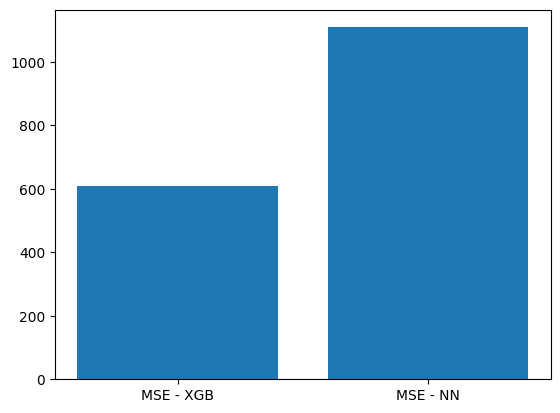

In [88]:
plt.bar(["MSE - XGB", "MSE - NN"] , [mse(xgb_preds, y_test), mse(nn_preds, y_test)], )

## Residuals

In [69]:
res_xgb = xgb_preds - y_test
res_nn = nn_preds.flatten() - y_test

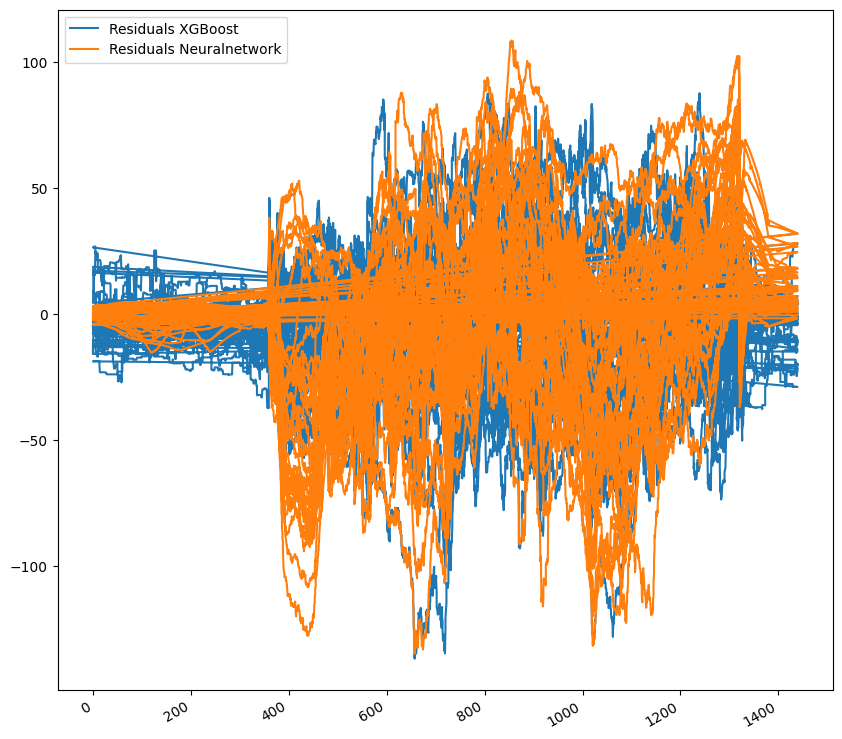

In [83]:
plt.figure(figsize=(10,10))
plt.plot(df[timemask]['minutes_since_midnight'], res_xgb, label = "Residuals XGBoost")
plt.plot(df[timemask]['minutes_since_midnight'], res_nn, label = "Residuals Neuralnetwork")
plt.gcf().autofmt_xdate()
#plt.xlim([start + pd.Timedelta(days=30),start + pd.Timedelta(days=32)])
plt.legend()

# Conclusion
XGB clearly performs better then the neuralnetwork. For this reason we will build the app using it. It also trains much faster.